# EDA de los datasets limpios y elección de las variables para el modelo de recomendación

En esta Jupyter Notebook se realiza el Análisis Exploratorio de los datos de los tres conjuntos de datos ya limpios para finalmente elegir las variables que serán usadas para entrenar el modelo de recomendación solicitado. Esto se hace dado que es un grán volumen de información y los recursos de procesamiento y almacenamiento, sobretodo al momento de deployar el proyecto, son limitados.

## Importaciones

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
import utils

import warnings
warnings.filterwarnings("ignore")

## EDA del dataset  `user_reviews`

En esta sección se desarrolla el Análisis Exploratorio de los Datos del conjunto `user_reviews` que ya pasó por el proceso de ETL.

### Lectura del conjunto de datos

Se leen los datos de .csv y se guarda en un dataframe.

In [2]:
df_reviews = pd.read_csv('data/user_review_limpio.csv', encoding='utf-8')
df_reviews.head()

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_date,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,2011-11-05,1
1,js41637,http://steamcommunity.com/id/js41637,251610,15 of 20 people (75%) found this review helpful,True,2014-06-24,1
2,evcentric,http://steamcommunity.com/id/evcentric,248820,No ratings yet,True,Formato inválido,2
3,doctr,http://steamcommunity.com/id/doctr,250320,2 of 2 people (100%) found this review helpful,True,2013-10-14,2
4,maplemage,http://steamcommunity.com/id/maplemage,211420,35 of 43 people (81%) found this review helpful,True,2014-04-15,1


Se revisan los tipos de datos y cantidad de nulos si hay.

In [3]:
# Se calcula la cantidad de registros
print(f'La cantidad de registros que hay son: {df_reviews.shape[0]}')
# Se revisan tipos de datos y existencias de nulos
utils.verificar_tipo_datos(df_reviews)

La cantidad de registros que hay son: 57397


,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,user_id,[<class 'str'>],100.0,0.0,0
1,user_url,[<class 'str'>],100.0,0.0,0
2,reviews_item_id,[<class 'int'>],100.0,0.0,0
3,reviews_helpful,[<class 'str'>],100.0,0.0,0
4,reviews_recommend,[<class 'bool'>],100.0,0.0,0
5,reviews_date,[<class 'str'>],100.0,0.0,0
6,sentiment_analysis,[<class 'int'>],100.0,0.0,0


Se tienen 57397 registros de opiniones de los usuarios respecto a los juegos que consumen. Si bien no hay nulos, hay que recordar que en el ETL se observaron datos faltantes en la columna 'reviews_date' donde se rellenó con 'Formato inválido'.

### Columnas 'sentiment_analysis' y 'reviews_recommend'

Se exploran las columnas 'sentiment_analysis' y 'reviews_recommend'.

In [4]:
utils.resumen_cant_porcentaje(df_reviews, 'sentiment_analysis')

,Cantidad,Porcentaje
1,35271,61.45
2,17100,29.79
0,5026,8.76


In [5]:
utils.resumen_cant_porcentaje(df_reviews, 'reviews_recommend')

,Cantidad,Porcentaje
True,50778,88.47
False,6619,11.53


De los registros de reviews casi el 62% de los reviews reflejan sentimientos neutrales, casi el 30% reflejan sentimientos positivos hacia el juego y menos del 9% fue negativo. Pero en el 88% de los reviews se recomiendan los juegos que consumen.

En el siguiente código se busca ver la cantidad de recomendaciones para los distintos sentimientos de las reviews.

In [6]:
# Se agrupa por 'sentiment_analysis' y 'reviews_recommend'
df_agrupado = df_reviews.groupby(['sentiment_analysis', 'reviews_recommend'])
# Se cuentan la cantidad de reviews en cada grupo
cantidad_grupo = df_agrupado.size()
# Se calcula el porcentaje por cada grupo
porcentaje_grupo = 100 * df_agrupado.size() / len(df_reviews)
# Se crea un datafram con el resumen
sentimiento_recomendacion = pd.DataFrame({
    "Cantidad": cantidad_grupo,
    "Porcentaje": porcentaje_grupo
})
sentimiento_recomendacion

Cantidad  Porcentaje
sentiment_analysis reviews_recommend                      
0                  False                  1652    2.878199
                   True                   3374    5.878356
1                  False                  4370    7.613638
                   True                  30901   53.837309
2                  False                   597    1.040124
                   True                  16503   28.752374

Se puede ver que el porcentaje respecto del total de los reviews que casi el 54% de los reviews que reflejan un sentimiento neutral recomienda el juego por lo que un sentimiento neutral podría estar relacionado con un comentario sencillo sin muchos detalles pero que aún así el juego le gustó como para recomendar. Por otra parte, de los comentarios que reflejaron un sentimiento negativo cerca del 6% aún recomienda el juego, lo que es algo contradictorio.

In [7]:
# Cantidad de usuarios que dieron su opinion
print(f"Cantidad de usuarios únicos que opinaron: {len(df_reviews['user_id'].unique())}")

Cantidad de usuarios únicos que opinaron: 25143


Un total de 25143 usurarios dieron su opinión sobre el juego que consumen, con lo que un usuario hizo mas de un comentario.

### Columna 'reviews_date'

Se revisan la cantidad de fechas con formato inválido o que no tenían fecha en el conjunto de datos original.

In [8]:
print(f'La cantidad de fechas en formato inválido son: {len(df_reviews[df_reviews["reviews_date"]=="Formato inválido"])}')

La cantidad de fechas en formato inválido son: 9771


Hay 9771 registros que no contienen la fecha del review.

En el siguiente gráfico se puede ver la distribución de la cantidad de reviews por día, sin tener en cuenta los que no tenía la fecha.

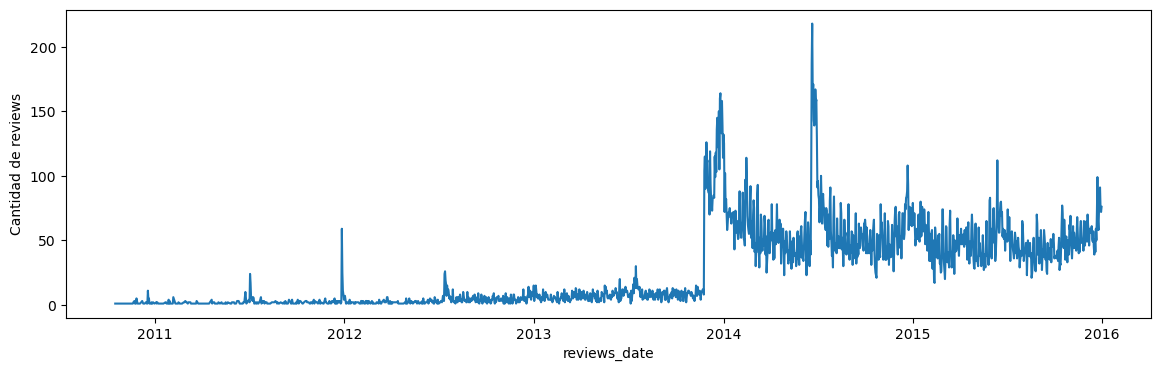

In [9]:
# Se hace un dataframe auxiliar para analizar solo las fechas (hay campos con 'Datos no disponibles')
df = df_reviews[df_reviews["reviews_date"].str.match(r"^\d{4}-\d{2}-\d{2}$")]
# Convierte a formato fecha
df["reviews_date"] = pd.to_datetime(df["reviews_date"])
# Calcula la cantidad de review por fecha
df_counts = df.groupby("reviews_date").count()

# Grafica
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_counts, x="reviews_date", y="reviews_recommend")
plt.ylabel('Cantidad de reviews')
plt.show()

In [10]:
print('Días de cantidad pico de reviews')
df_counts.sort_values(by='reviews_recommend', ascending=False)['reviews_recommend'][:5]

Días de cantidad pico de reviews


reviews_date
2014-06-21    218
2014-06-20    187
2014-06-23    171
2014-06-27    167
2013-12-26    164
Name: reviews_recommend, dtype: int64

Se observa que hasta cerca del 2014 la cantidad de reviews por día es bajo, con algunos picos puntuales y luego aumenta considerablemente la cantidad de comentarios con un pico máximo el 21-06-2014 con 218 comentarios en un solo día.

## EDA del dataset  `steam_games`

En esta sección se desarrolla el Análisis Exploratorio de los Datos del conjunto `steam_games` que ya pasó por el proceso de ETL.

### Lectura del conjunto de datos

Se leen los datos de .csv y se guarda en un dataframe.

In [11]:
df_games = pd.read_csv('data/steam_games_limpio.csv', encoding='utf-8')
df_games.head()

,genres,price,early_access,id,release_anio,publisher,app_name,title,developer
0,Action,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
1,Casual,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
2,Indie,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
3,Simulation,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
4,Strategy,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro


Se revisan los tipos de datos y cantidad de nulos si hay.

In [12]:
# Se calcula la cantidad de registros
print(f'La cantidad de registros que hay son: {df_games.shape[0]}')
# Se revisan tipos de datos y existencias de nulos
utils.verificar_tipo_datos(df_games)

La cantidad de registros que hay son: 71551


,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,genres,[<class 'str'>],100.00,0.00,0
1,price,[<class 'float'>],100.00,0.00,0
2,early_access,[<class 'bool'>],100.00,0.00,0
3,id,[<class 'int'>],100.00,0.00,0
4,release_anio,[<class 'str'>],100.00,0.00,0
5,publisher,"[<class 'str'>, <class 'float'>]",99.97,0.03,22
6,app_name,[<class 'str'>],100.00,0.00,0
7,title,[<class 'str'>],100.00,0.00,0
8,developer,[<class 'str'>],100.00,0.00,0


Este conjunto de datos tiene 9 columnas y 71551 registros. Para recordar, contiene la información relacionada a cada juego como el precio, el año de lanzamiento, el nombre de la aplicación y del juego, el desarrollador y el publicitador, así como el género. Hay que tener en cuenta que la información se repite porque un juego puede pertenecer a mas de un género.

### Columnas 'id', 'app_name' y 'title'

Estas columnas hacen referencia al identificador único del juego y los nombres de la aplicación y del título del juego. Estos últimos no tienen mayor información que analizar en este momento. Con el 'id' se puede calcular la cantidad de juegos.

In [13]:
total_juegos = len(df_games['id'].unique())
print(f"El total de juegos que hay registrados son: {total_juegos}")

El total de juegos que hay registrados son: 28850


Hay un total de 28850 juegos en la plataforma.

### Columna 'genres'

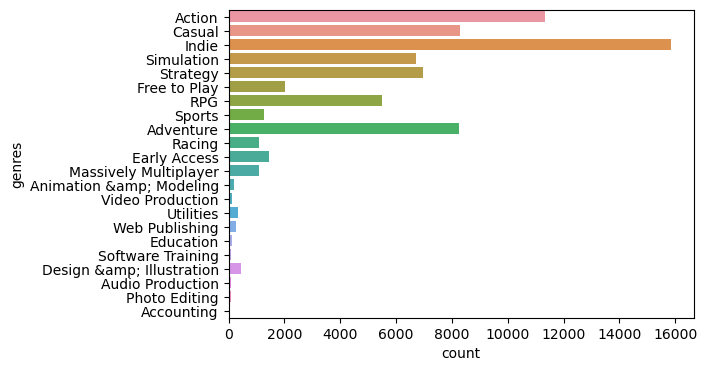

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_games, y='genres', orient='h')
plt.show()

In [15]:
utils.resumen_cant_porcentaje(df_games, 'genres')

,Cantidad,Porcentaje
Indie,15858,22.16
Action,11319,15.82
Casual,8282,11.57
Adventure,8242,11.52
Strategy,6957,9.72
Simulation,6699,9.36
RPG,5479,7.66
Free to Play,2031,2.84
Early Access,1462,2.04
Sports,1257,1.76


Los juegos estan categorizados mayormente en las categorías *Indi*, *Action*, *Casual* y *Adventure*. Cabe recordar que un juego puede tener mas de un género asociado.

### Columna 'release_anio'

In [16]:
utils.resumen_cant_porcentaje(df_games, 'release_anio')[:10]

,Cantidad,Porcentaje
2017,24967,34.89
2016,17667,24.69
2015,12256,17.13
2014,6341,8.86
2013,3016,4.22
2012,2106,2.94
2011,986,1.38
Dato no disponible,850,1.19
2010,653,0.91
2009,486,0.68


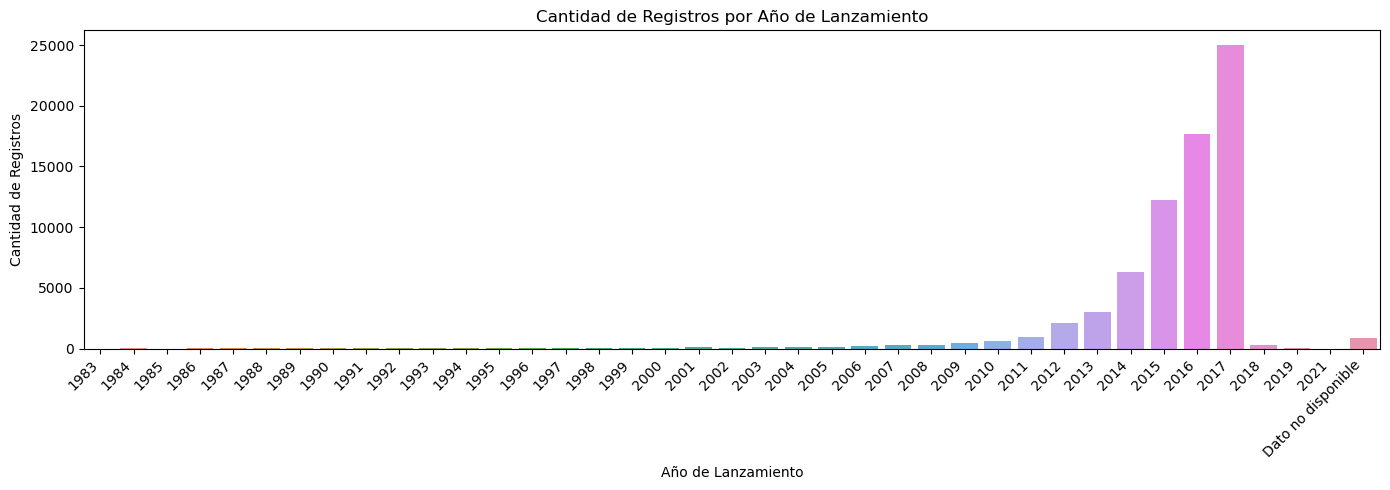

In [17]:
# Cuenta la frecuencia de cada año
conteo_anios = df_games['release_anio'].value_counts()

# Ordena los valores para que 'Datos no disponibles' queden al principio o al final
conteo_anios = conteo_anios.reindex(['Dato no disponible'] + list(conteo_anios.index))
# Ordena los valores por año
conteo_anios = conteo_anios.sort_index()

# Crear la gráfica de barras
plt.figure(figsize=(14, 5))
sns.barplot(x=conteo_anios.index, y=conteo_anios.values)
plt.xlabel('Año de Lanzamiento') ; plt.ylabel('Cantidad de Registros') ; plt.title('Cantidad de Registros por Año de Lanzamiento')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# Filtra los registros con valores numéricos en la columna 'release_anio'
registros_numericos = df_games[df_games['release_anio'].str.isnumeric()]
# Convierte la columna 'release_anio' a valores enteros
registros_numericos['release_anio'] = registros_numericos['release_anio'].astype(int)
# Filtra los registros con años de lanzamiento antes de 2002
registros_antes_2002 = registros_numericos[registros_numericos['release_anio'] < 2002]

print(f"Cantidad de registros antes de 2002: {len(registros_antes_2002)}")
print(f"Cantidad de registros 'Dato no disponible': {df_games[df_games['release_anio'] == 'Dato no disponible'].shape[0]}")

Cantidad de registros antes de 2002: 679
Cantidad de registros 'Dato no disponible': 850


Se pueden ver 679 juegos lanzados en años anteriores al 2002 lo que puede ser un error porque la plataforma se lanzó en el 2003. Por otra parte, se observan 850 juegos sin la fecha disponible debido a que no estaba especificada o estaba en un formato incorrecto. Luego se ve el crecimiento constante y lento hasta 2012 y luego crece mas rápidamente hasta 2017. A partir de allí, la plataforma limitó la forma de obtener las estadísticas, por eso se ven muchos menos registros.

### Columnas 'publisher' y 'developer'

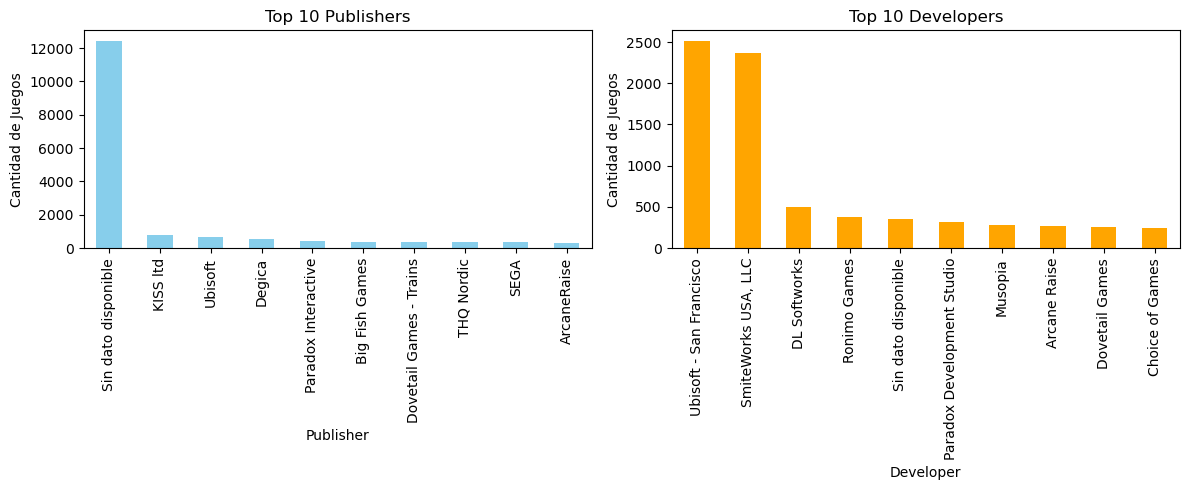

In [19]:
# Contar la cantidad de juegos por publisher
conteo_publisher = df_games['publisher'].value_counts()

# Contar la cantidad de juegos por developer
conteo_developer = df_games['developer'].value_counts()

# Crear una figura con dos subplots uno al lado del otro
plt.figure(figsize=(12, 5))

# Primer subplot para los publishers
plt.subplot(1, 2, 1)
conteo_publisher[:10].plot(kind='bar', color='skyblue')
plt.xlabel('Publisher') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 10 Publishers')

# Segundo subplot para los developers
plt.subplot(1, 2, 2)
conteo_developer[:10].plot(kind='bar', color='orange')
plt.xlabel('Developer') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 10 Developers')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

En el caso de los publicista de juegos, la mayor cantidad no dispone del dato y en el caso de los desarrolladores, Ubisoft y SmiteWorks son los desarrolladores que mas juegos han desarrollado para la plataforma.

### Columna 'price'

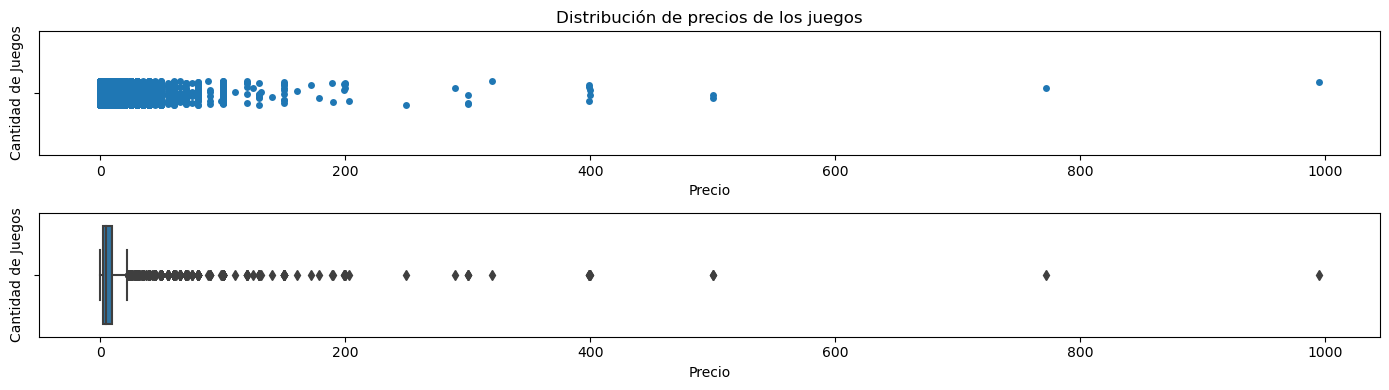

In [25]:
# Obtiene los precios para cada juego y hace un dataframe
precio_unicos = df_games.groupby('id')['price'].unique().reset_index().explode('price')
df_precio_unicos = precio_unicos['price']

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=df_precio_unicos, x=df_precio_unicos, ax=ax1)
ax1.set_xlabel('Precio') ; ax1.set_ylabel('Cantidad de Juegos') ; ax1.set_title('Distribución de precios de los juegos')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=df_precio_unicos, x=df_precio_unicos, ax=ax2)
ax2.set_xlabel('Precio') ; ax2.set_ylabel('Cantidad de Juegos')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [26]:
estadisticas = df_precio_unicos.astype(float).describe()
print(f'El precio medio (mediana) de los juegos es de: {estadisticas[5]}')
print(f'El precio promedio (mean) de los juegos es de: {round(estadisticas[1],2)}')
print(f'El 75% de los juegos tienen un precio menor de: {estadisticas[6]}')
utils.bigote_max(pd.DataFrame(df_precio_unicos.astype(float))['price'])

El precio medio (mediana) de los juegos es de: 4.99
El precio promedio (mean) de los juegos es de: 8.62
El 75% de los juegos tienen un precio menor de: 9.99
El bigote superior de la variable price se ubica en: 21.99
Hay 1746 valores atípicos en la variable price


Se puede ver que casi el 50% de los juegos tienen precios entre 0 y los 4.99 dolares y el 75% de los juegos tienen precios inferior a los 9.99 dolares. Se Observan 1746 valores que se pueden considerar atípicos, con precios superior a los 21.99 dolares, pero sin dudas hay algunos juegos de mas de 250 dolares que pueden considerarse errores en los precios.

## EDA del dataset  `users_items`

En esta sección se desarrolla el Análisis Exploratorio de los Datos del conjunto `users_items`  que ya pasó por el proceso de ETL.

### Lectura del conjunto de datos

Se leen los datos de .csv y se guarda en un dataframe.

In [27]:
df_items = pd.read_csv('data/user_items_limpio.csv', encoding='utf-8')
df_items.head()

,item_id,item_name,playtime_forever,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...


Se revisan los tipos de datos y cantidad de nulos si hay.

In [28]:
# Se calcula la cantidad de registros
print(f'La cantidad de registros que hay son: {df_items.shape[0]}')
# Se revisan tipos de datos y existencias de nulos
utils.verificar_tipo_datos(df_items)

La cantidad de registros que hay son: 5094105


,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,item_id,[<class 'int'>],100.0,0.0,0
1,item_name,[<class 'str'>],100.0,0.0,0
2,playtime_forever,[<class 'int'>],100.0,0.0,0
3,steam_id,[<class 'int'>],100.0,0.0,0
4,items_count,[<class 'int'>],100.0,0.0,0
5,user_id,[<class 'str'>],100.0,0.0,0
6,user_url,[<class 'str'>],100.0,0.0,0


Este conjunto de datos tiene 7 columnas y 5094105 registros. Para recordar, contiene la información relacionada los usuarios y los juegos que consumen como el tiempo acumulado (en minutos) que han jugado a un juego, la cantidad de items que consumen así como los identificadores de los juegos que consumen y del propio usuario y la url del perfil del mismo.

### Columna 'playtime_forever'

Estas columnas hacen referencia al tiempo en minutos acumulados que un usuario ha jugado.

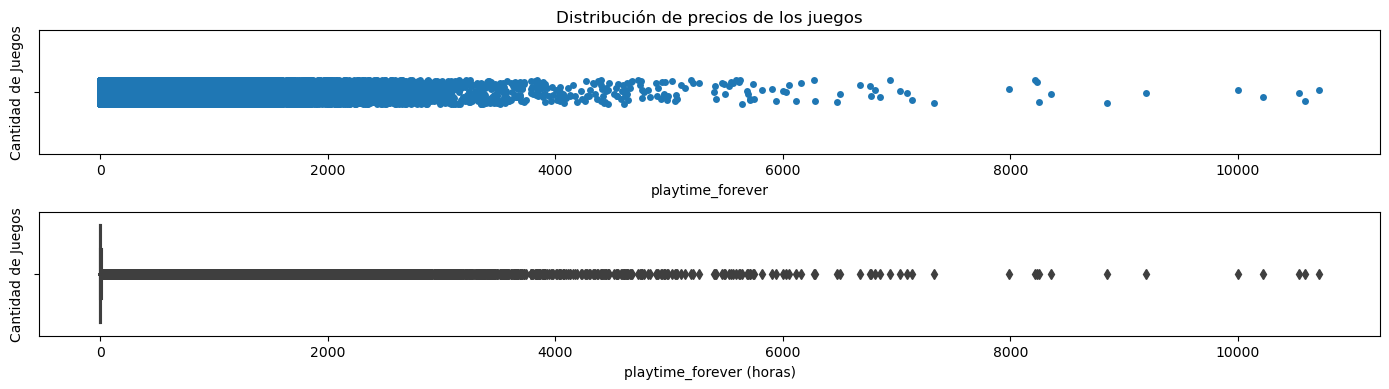

In [31]:
df_items['playtime_hours'] = df_items['playtime_forever'] / 60

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=df_items, x='playtime_hours', ax=ax1)
ax1.set_xlabel('playtime_forever') ; ax1.set_ylabel('Cantidad de Juegos') ; ax1.set_title('Distribución de precios de los juegos')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=df_items, x='playtime_hours', ax=ax2)
ax2.set_xlabel('playtime_forever (horas)') ; ax2.set_ylabel('Cantidad de Juegos')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [32]:
estadisticas = df_items['playtime_hours'].describe()
print(f'El precio medio (mediana) de los juegos es de: {round(estadisticas[5],2)}')
print(f'El precio promedio (mean) de los juegos es de: {round(estadisticas[1],2)}')
print(f'El 75% de los juegos tienen un precio menor de: {round(estadisticas[6],2)}')
utils.bigote_max(df_items['playtime_hours'])

El precio medio (mediana) de los juegos es de: 0.57
El precio promedio (mean) de los juegos es de: 16.51
El 75% de los juegos tienen un precio menor de: 5.92
El bigote superior de la variable playtime_hours se ubica en: 14.79
Hay 763606 valores atípicos en la variable playtime_hours


Se puede observar que cada usuario, por juego, pasa un tiempo medio de 0.57 hs jugando y el 75% de los jugadores estuvieron menos de 6 hs jugando a un juego, pero se observa una gran cantidad de valores atípicos por encima de las 14.79 hs que juega cada usuario a un juego. Esto podría deberse al uso de bots que utilizan el mismo perfil de usuario para jugar en simultaneo, lo que generaría una distorsión de los tiempos reales de juego.

### Columna 'items_count'

Esta columna indica la cantidad de juegos que consumen o compraron alguna vez los usuarios.

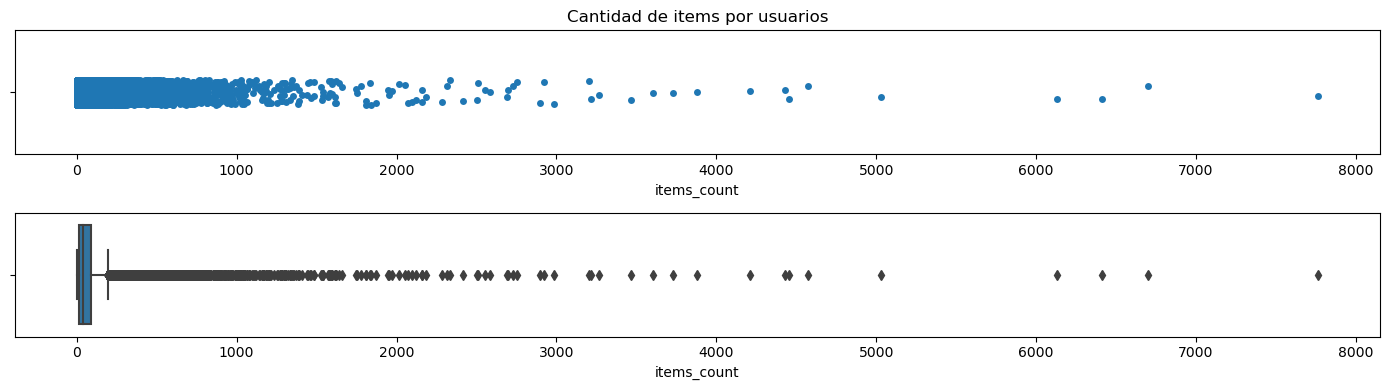

In [33]:
# Agrupa por usuario la cantidad de items, lo conviente en data frame y los ordena de mayor a menor
items_count_user = df_items.groupby('user_id')['items_count'].unique().explode()
items_count_user = pd.DataFrame(items_count_user)
items_count_user_o = items_count_user.sort_values('items_count', ascending=False)

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=items_count_user_o, x='items_count', ax=ax1)
ax1.set_xlabel('items_count') ; ax1.set_title('Cantidad de items por usuarios')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=items_count_user_o, x='items_count', ax=ax2)
ax2.set_xlabel('items_count')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [34]:
estadisticas = items_count_user['items_count'].astype(float).describe()
print(f'El precio medio (mediana) de los juegos es de: {round(estadisticas[5],2)}')
print(f'El precio promedio (mean) de los juegos es de: {round(estadisticas[1],2)}')
print(f'El 75% de los juegos tienen un precio menor de: {round(estadisticas[6],2)}')
utils.bigote_max(items_count_user.astype(float)['items_count'])

El precio medio (mediana) de los juegos es de: 40.0
El precio promedio (mean) de los juegos es de: 71.84
El 75% de los juegos tienen un precio menor de: 87.0
El bigote superior de la variable items_count se ubica en: 196.5
Hay 4957 valores atípicos en la variable items_count


<Figure size 1400x500 with 0 Axes>

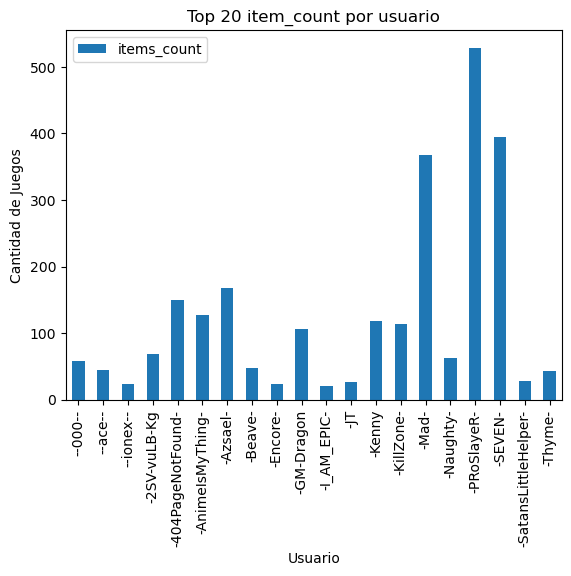

In [35]:
# Grafica cantidad de item por usuarios
plt.figure(figsize=(14, 5))
items_count_user[:20].plot(kind='bar')
plt.xlabel('Usuario') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 20 item_count por usuario')
plt.show()

Se puede ver que el usuario que mas cantidad de juegos a consumido ronda los 8000 juegos, pero el 75% de los usuarios ha adquirido menos de 87 items. Se pueden ver 4957 usuarios que hay adquirido mas de 196 items que podrían considerarse como atípicos.